### Data cleaning steps:

DO NOT re-run this notebook for fun...takes a long time to finish

1. Clean BSR data
  - drop products that don't start with B
  - within asin-date, take averaged rank and avg180_price
  - drop products with < 200 ranks
  - insert dates where the original dataset does not have rank/price information (did not impute rank/price---leave the columns as NaN but has a row for them)
  - save intermediate dataset to intermediate/bsr_filtered.csv

2. Clean review data
  - drop products that don't start with B
  - drop reviews before 2017 sincewe only have BSR data after July 2017
  - drop reviewcommentcount since it's all 0
  - rename review_date to date
  - save intermediate dataset to intermediate/review_filter.csv

3. "Merge" the two datasets
  - drop ranks 90 days before the first review
  - take products that exist both in review dataset and in bsr dataset
  - clean/dat_prod_key.csv has a map from a unique identifier to a date-prod combo
  - clean/rev.csv has the cleaned review dataset
  - clean/bsr.csv has the cleaned bsr dataset


Intermediate files saved to: 
- `intermediate/bsr_filtered.csv`
- `intermediate/review_filtered.csv`

Output to:
- `clean/bsr.csv`
- `clean/rev.csv`

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# input folders
in_data = "/content/drive/My Drive/297R-Caps-Pattern/Data/raw"

# intermediate folders
int_data = "/content/drive/My Drive/297R-Caps-Pattern/Data/intermediate"

# output folders
out_data = "/content/drive/My Drive/297R-Caps-Pattern/Data/clean"

### BSR Data

In [ ]:
# load bsr datasets
bsr_full = pd.read_csv(f'{in_data}/asin_bsr_history.csv')

# drop products without a Bxxxx asin
bsr_full = bsr_full[bsr_full['asin'].str[0] == 'B'].copy()

# within asin-date, take averaged rank and avg180_price
bsr_full = bsr_full.drop('Unnamed: 0',axis=1)
bsr_full = bsr_full.groupby(['date', 'asin'])[['rank', 'avg180_price']].mean().reset_index()

this leaves 0.9155155155155155 of data


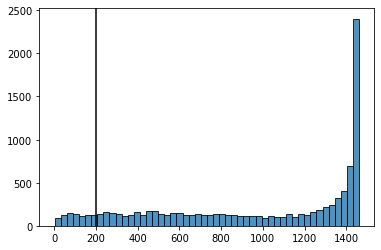

In [ ]:
# drop products with < 200 ranks
freq_cutoff = 200
freq = bsr_full.groupby('asin')['date'].count()
plt.hist(freq, bins=50, edgecolor='k', alpha=0.8);
plt.axvline(x=freq_cutoff, c='k');
print('this leaves', (freq >= freq_cutoff).mean(), 'of data')
asin_to_keep = freq[freq >= freq_cutoff].index
bsr_full['count'] = bsr_full.groupby('asin')['date'].transform('count')
bsr_full = bsr_full.query(f'count>={freq_cutoff}').copy()
bsr_full = bsr_full.drop('count',axis=1)

In [ ]:
bsr_full.head()

,date,asin,rank,avg180_price
0,2017-07-03,B000052XB5,1254.166667,11.98
1,2017-07-03,B00005313T,3805.750000,33.73
2,2017-07-03,B0000533I2,8918.000000,23.59
3,2017-07-03,B00005K9DO,199998.500000,11.97
4,2017-07-03,B0000645VY,4093.750000,17.37


In [ ]:
# get the list of asin with missing dates
bsr_full['date'] = pd.to_datetime(bsr_full['date'])
bsr_start = bsr_full.groupby(['asin'])['date'].min().to_frame().reset_index().rename(columns={'date':'start'})
bsr_end = bsr_full.groupby(['asin'])['date'].max().to_frame().reset_index().rename(columns={'date':'end'})
bsr_dates = bsr_start.merge(bsr_end, on='asin', how='outer')
del bsr_start 
del bsr_end
bsr_dates['start'] = pd.to_datetime(bsr_dates['start'])
bsr_dates['end'] = pd.to_datetime(bsr_dates['end'])
bsr_dates['days_in_bw'] = (bsr_dates['end'] - bsr_dates['start']).dt.days + 1 
bsr_dates = bsr_dates.merge(bsr_full.groupby('asin')['date'].size().reset_index().rename(columns={'date':'n_rank'}),
                            on='asin',how='outer')
bsr_dates['missing_days'] = bsr_dates['days_in_bw'] - bsr_dates['n_rank']
assert (bsr_dates['missing_days'] >=0).all()
asin_w_missing_asin = bsr_dates.query('missing_days > 0')['asin']
del bsr_dates

In [ ]:
# loop through products to fill in dates 
for this_asin in tqdm(asin_w_missing_asin):
  temp = bsr_full.query(f'asin=="{this_asin}"')[['asin','date']].copy()
  temp.index = pd.DatetimeIndex(temp['date'])
  idx = pd.date_range(temp.index.min(), temp.index.max())
  temp = temp.reindex(idx)
  temp = temp.drop('date', axis=1).reset_index().rename(columns={'index':'date'})
  temp['asin'] = this_asin
  bsr_full = bsr_full.merge(temp, on=['date','asin'], how='outer').copy()

In [ ]:
rev_full.to_csv(f'{int_data}/review_filtered.csv',index=False)

### Review Data

In [ ]:
# load review datasets
rev_full = pd.read_csv(f'{in_data}/asin_review_history.csv')
rev_full = rev_full.drop('Unnamed: 0', axis=1)

In [ ]:
# drop products without a Bxxxx asin
rev_full = rev_full[rev_full['asin'].str[0] == 'B'].copy()

# drop duplicates based on all columns
rev_full = rev_full.drop_duplicates()

# drop review before 2017 
# we only have BSR data after July 2017
rev_full = rev_full.query('review_date >= "2017-01-01"').copy()

# drop reviewcommentcount since it's all 0
rev_full = rev_full.drop('reviewcommentcount', axis=1).copy()

# rename review date to date
rev_full = rev_full.rename(columns={'review_date':'date'})

In [ ]:
rev_full.head()

,asin,product_name,review_title,review_text,reviewrating,date,reviewvotes,reviewverifiedpurchase,temp,country_name
0,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Solution to pouring and storing,This review is being posted more as a solution...,5.0,2017-07-27,"1,652 people found this helpful",True,"Reviewed in the United States on July 27, 2017",United States
1,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Works far beyond my expectations.,I work with my husband. He asked me what has g...,5.0,2018-01-09,591 people found this helpful,True,"Reviewed in the United States on January 9, 2018",United States
2,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,"When you take the cap off,","When you take the cap off, just poke a hole in...",4.0,2017-02-08,"1,205 people found this helpful",True,"Reviewed in the United States on February 8, 2017",United States
3,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,I'm not even sure this is legit bulletproof oi...,I normally order directly from bulletproof. Am...,1.0,2017-10-11,545 people found this helpful,True,"Reviewed in the United States on October 11, 2017",United States
4,B00R7FFYO8,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Getting a definite bump in energy during the day.,I've been using this daily for 3 weeks now. I ...,4.0,2017-06-16,857 people found this helpful,True,"Reviewed in the United States on June 16, 2017",United States


In [ ]:
rev_full.to_csv(f'{int_data}/review_filtered.csv',index=False)

### Merge

In [ ]:
# load bsr datasets
bsr_full = pd.read_csv(f'{int_data}/bsr_filtered.csv')
rev_full = pd.read_csv(f'{int_data}/review_filtered.csv')

bsr_full['date'] = pd.to_datetime(bsr_full['date'])
rev_full['date'] = pd.to_datetime(rev_full['date'])

In [ ]:
# drop ranks way (90 days) before the first review
min_rev = rev_full.groupby('asin')['date'].min().to_frame().reset_index().rename(columns={'date':'rev'}) 
bsr_full = bsr_full.merge(min_rev, how="left", on="asin").assign(rev_minus_90=lambda x : x["rev"] - pd.DateOffset(90, "d"))
bsr_full = bsr_full.loc[bsr_full["date"] >= bsr_full["rev_minus_90"]].copy()
bsr_full = bsr_full.drop(['rev', 'rev_minus_90'], axis=1)

In [ ]:
# product sample is the intersect of reviews and reviews
rev_prod = rev_full[['asin']].drop_duplicates().copy()
bsr_prod = bsr_full[['asin']].drop_duplicates().copy()

prod_sample = rev_prod.merge(bsr_prod, on='asin', how='inner')
print(prod_sample.shape[0], 'product remains')

rev_full = rev_full.merge(prod_sample, on='asin', how='right').copy()
bsr_full = bsr_full.merge(prod_sample, on='asin', how='right').copy()

9121 product remains


In [ ]:
rev_date_prod = rev_full[['asin', 'date']].drop_duplicates().copy()
bsr_date_prod = bsr_full[['asin', 'date']].drop_duplicates().copy()

In [ ]:
# get a df of unique date and asin 
date_prod = rev_date_prod.merge(bsr_date_prod, on=['asin', 'date'], how='outer').sort_values(['date', 'asin'])

# add foreigh key
date_prod = date_prod.reset_index().rename(columns={'index': 'dat_prod_key'})
date_prod.to_csv(f'{out_data}/dat_prod_key.csv',index=False)

In [ ]:
rev_full = rev_full.merge(date_prod, on=['asin','date'], how='left')
bsr_full = bsr_full.merge(date_prod, on=['asin','date'], how='left')
rev_full = rev_full[['dat_prod_key', 'asin', 'date', 'product_name', 'review_title', 'review_text', 'reviewrating','reviewvotes', 'reviewverifiedpurchase', 'temp', 'country_name']]
bsr_full = bsr_full[['dat_prod_key', 'asin', 'date', 'rank','avg180_price']]

In [ ]:
rev_full

,dat_prod_key,asin,date,product_name,review_title,review_text,reviewrating,reviewvotes,reviewverifiedpurchase,temp,country_name
0,0,B00R7FFYO8,2017-07-27,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Solution to pouring and storing,This review is being posted more as a solution...,5.0,"1,652 people found this helpful",True,"Reviewed in the United States on July 27, 2017",United States
1,1,B00R7FFYO8,2018-01-09,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Works far beyond my expectations.,I work with my husband. He asked me what has g...,5.0,591 people found this helpful,True,"Reviewed in the United States on January 9, 2018",United States
2,2,B00R7FFYO8,2017-02-08,Brain Octane Premium C8 MCT Oil from Non-GMO C...,"When you take the cap off,","When you take the cap off, just poke a hole in...",4.0,"1,205 people found this helpful",True,"Reviewed in the United States on February 8, 2017",United States
3,3,B00R7FFYO8,2017-10-11,Brain Octane Premium C8 MCT Oil from Non-GMO C...,I'm not even sure this is legit bulletproof oi...,I normally order directly from bulletproof. Am...,1.0,545 people found this helpful,True,"Reviewed in the United States on October 11, 2017",United States
4,4,B00R7FFYO8,2017-06-16,Brain Octane Premium C8 MCT Oil from Non-GMO C...,Getting a definite bump in energy during the day.,I've been using this daily for 3 weeks now. I ...,4.0,857 people found this helpful,True,"Reviewed in the United States on June 16, 2017",United States
...,...,...,...,...,...,...,...,...,...,...,...
4121793,1738515,B07Y41M5H8,2021-04-04,"Multi Collagen Pills (Type I, II, III, V, X) H...",Coconut makes them smell and taste great,Coconut makes them smell and taste great. Very...,5.0,NaN,True,"Reviewed in the United States on April 4, 2021",United States
4121794,1738516,B07Y41M5H8,2021-03-11,"Multi Collagen Pills (Type I, II, III, V, X) H...",Trusted Brand,Easy to swallow. Love SR products,5.0,NaN,True,"Reviewed in the United States on March 11, 2021",United States
4121795,1738517,B07Y41M5H8,2021-02-16,"Multi Collagen Pills (Type I, II, III, V, X) H...",The Collagen really has decreased my arthritis...,The Collagen is helping with my joint pain. Es...,5.0,One person found this helpful,True,"Reviewed in the United States on February 16, ...",United States
4121796,1738430,B07Y41M5H8,2021-03-16,"Multi Collagen Pills (Type I, II, III, V, X) H...",Seems to help,a little improvement in skin and joints.,5.0,NaN,True,"Reviewed in the United States on March 16, 2021",United States


In [ ]:
bsr_full

,dat_prod_key,asin,date,rank,avg180_price
0,1004,B00R7FFYO8,2017-07-03,768.857143,41.393333
1,33,B00R7FFYO8,2017-07-04,767.000000,41.393333
2,54,B00R7FFYO8,2017-07-05,860.625000,41.393333
3,381,B00R7FFYO8,2017-07-06,919.500000,41.393333
4,1266,B00R7FFYO8,2017-07-07,981.285714,41.393333
...,...,...,...,...,...
10263311,10483729,B07Y41M5H8,2019-10-17,NaN,NaN
10263312,10483730,B07Y41M5H8,2019-10-19,NaN,NaN
10263313,10483731,B07Y41M5H8,2019-10-20,NaN,NaN
10263314,10483732,B07Y41M5H8,2019-10-21,NaN,NaN


In [ ]:
bsr_full.to_csv(f'{out_data}/bsr.csv',index=False)
rev_full.to_csv(f'{out_data}/rev.csv',index=False)

### Load in clean dataset to check formatting

In [ ]:
bsr = pd.read_csv(f'{out_data}/bsr.csv')
rev = pd.read_csv(f'{out_data}/rev.csv')

In [ ]:
rev_full = pd.read_csv(f'{in_data}/asin_review_history.csv')
bsr_full = pd.read_csv(f'{in_data}/asin_bsr_history.csv')